In [1]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Comparison on multiple datasets

In [2]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
import sys
sys.path.append('./EXPLAN')
import explan
from utils import *
from LORE import lore
from LORE.neighbor_generator import *

In [4]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [5]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [6]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [7]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    y_test_appended = np.concatenate([y_test,[1]])
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [8]:
shap.initjs()

In [9]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [10]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


Accuracy  model: 0.8745551601423488 for data_house_16H
----------- Model certainty for instance: 0.7874016516623215 ---------------
Neighbourhood size: 250
Average distace of neighbourhood: 1.8381460770445741.
Train sample size: 869 (0.08590351917754054)


Permutation explainer: 871it [01:46,  7.44it/s]                                                                                                                    


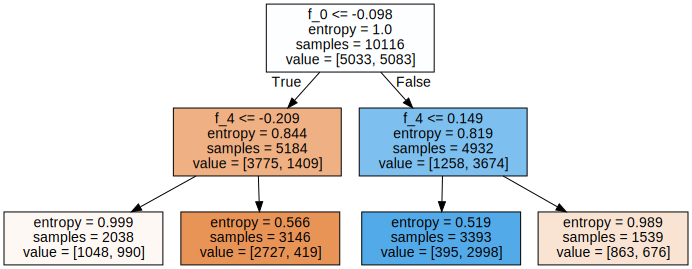

Fidelity  dectree: 0.904
Accuracy  dectree: 0.848
Lux ww proba
In fact using: 0.08590351917754054 samples from train set wiuth class balance: 0.4522439585730725


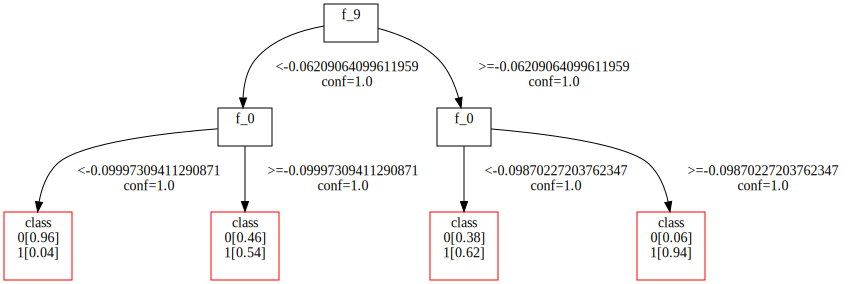

IF f_9  < -0.06209064099611959 AND f_0  < -0.09997309411290871 THEN class = 0 # 0.9568965517241379



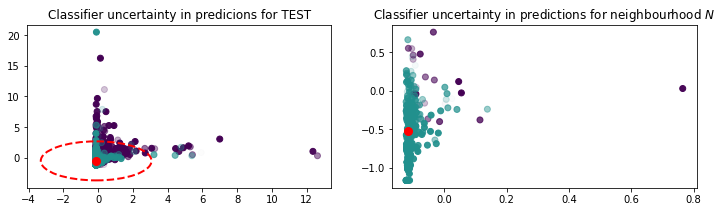

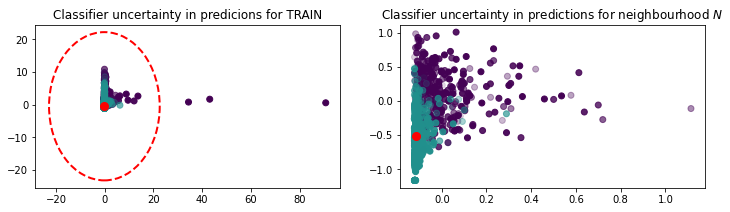

--- 128.0196726322174 seconds ---
Fidelity  no proba: 0.72
Accuracy  no proba: 0.712
Lux w proba
In fact using: 0.08590351917754054 samples from train set wiuth class balance: 0.4522439585730725


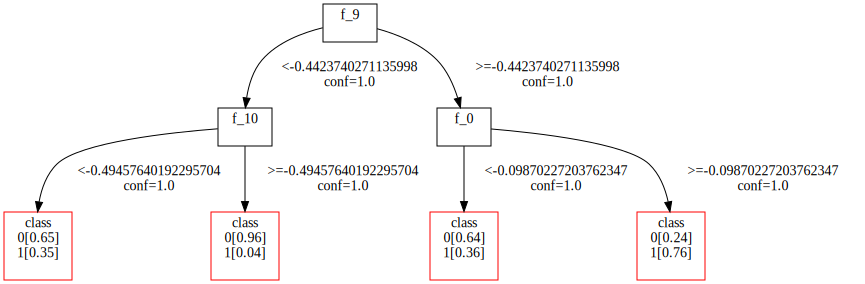

IF f_9  < -0.4423740271135998 AND f_10  >= -0.49457640192295704 THEN class = 0 # 0.9593598707790602



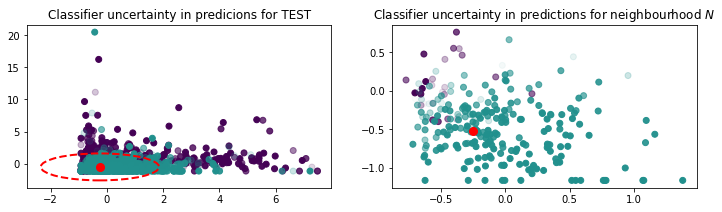

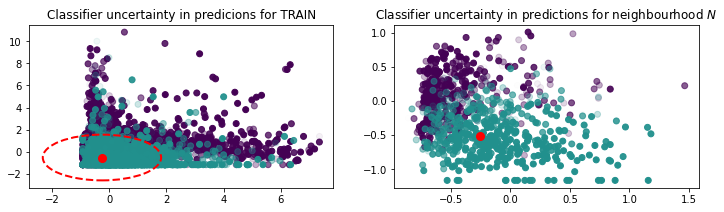

--- 141.4580101966858 seconds ---
Fidelity  with proba: 0.856
Accuracy  with proba: 0.816
Lux w shap
In fact using: 0.08590351917754054 samples from train set wiuth class balance: 0.4522439585730725


Permutation explainer: 870it [01:47,  7.30it/s]                                                                                                                    


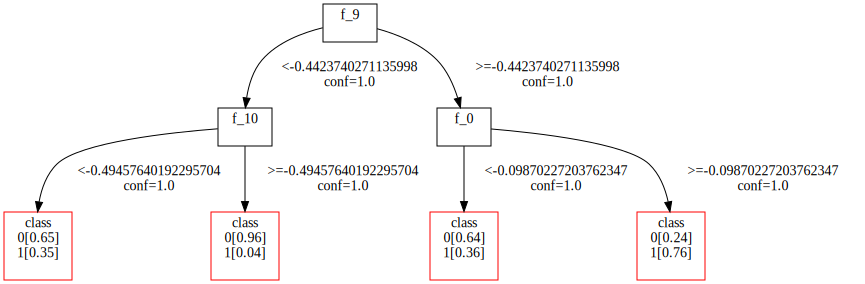

IF f_9  < -0.4423740271135998 AND f_10  >= -0.49457640192295704 THEN class = 0 # 0.9593598707790602



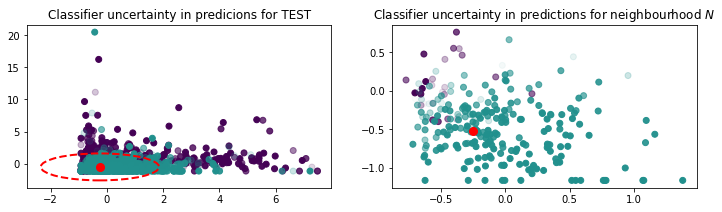

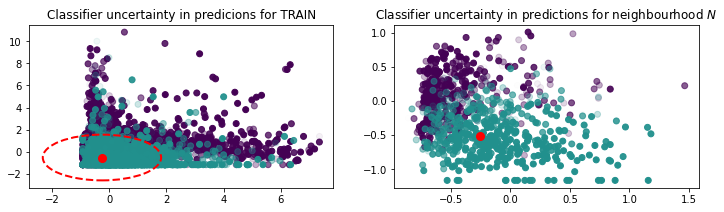

--- 308.2284083366394 seconds ---
Fidelity  with shap: 0.856
Accuracy  with shap: 0.816
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 16 class: 1 weight: 0 rows: 650\n + load time: 0.012222 secs (16.29 MiB/s, 53.18 K rows/s)\n + indexing ... done\n + total time: 0.017279 secs (11.52 MiB/s, 37.61 K rows/s)\nBuilding 1 tree(s) on 650 cases\n + tree(s) built\n + size: 7 depth: 2 nf: 3 time: 0.016134 secs\nPruning tree using training set\n + tree pruned\n + size: 5 depth: 2 nf: 2 time: 8e-06 secs\n'
Fidelity  EXPLAN: 0.82
Accuracy  EXPLAN: 0.796
EXPLAN expl e = {'f_9': '<=0.211008', 'f_7': '<=0.439690'}
----------- Model certainty for instance: 0.9984426821383625 ---------------
Neighbourhood size: 250
Average distace of neighbourhood: 2.2296503194292367.
Train sample size: 959 (0.09480031633056545)


Permutation explainer: 961it [01:51,  7.83it/s]                                                                                                                    


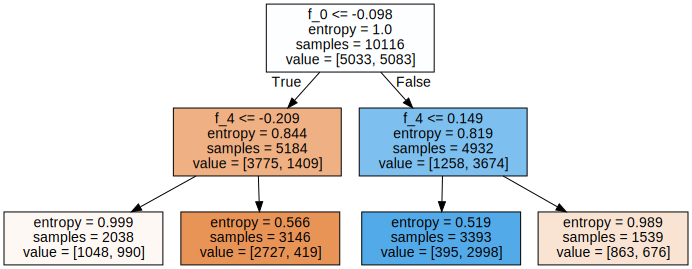

Fidelity  dectree: 0.788
Accuracy  dectree: 0.7
Lux ww proba
In fact using: 0.09480031633056545 samples from train set wiuth class balance: 0.40145985401459855


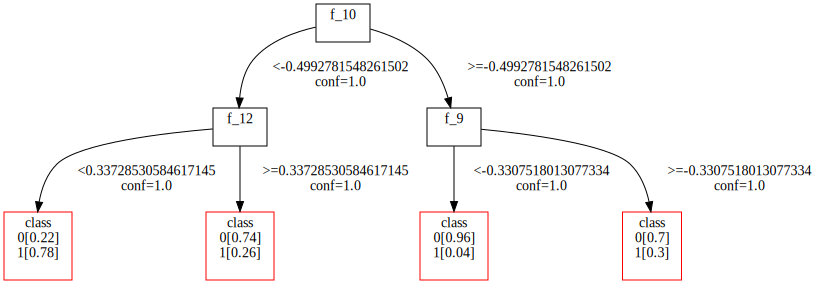

IF f_9  < -0.3307518013077334 AND f_10  >= -0.4992781548261502 THEN class = 0 # 0.960431654676259



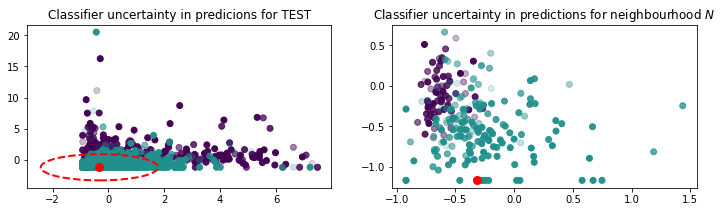

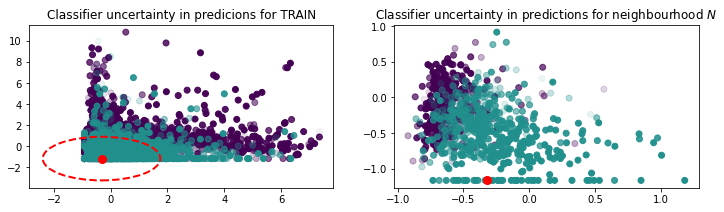

--- 134.3494520187378 seconds ---
Fidelity  no proba: 0.808
Accuracy  no proba: 0.728
Lux w proba
In fact using: 0.09480031633056545 samples from train set wiuth class balance: 0.40145985401459855


In [ ]:
import time
nac_data  = []
fid_data = []
imp_fid_data=[]
features_data = []
stability_data = []
rs=42
init_fraction=0.2
directory = './data/numerical_only/balanced'
#directory = './data/num_and_cat/balanced'
up=True
depth = 2
SAMPLE_SIZE=20
show=True
ismpl=True
synthetic = False
density_sampling=True
radius_sampling=False#True
oversampling=False
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_NEAREST
categorical_indicator=None
n_jobs=-1

for num_and_cat in  os.listdir(directory):
    #(data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    features = [f'f_{i}' for i in range(0,data.shape[1])]
    if directory =='./data/numerical_only/balanced':
        categorical_indicator=[False]*len(features)
    continuous_indicator = np.logical_not(categorical_indicator)
    target = 'class'
    df = pd.DataFrame(data,columns=features,dtype=float)
    sc = StandardScaler()
    df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
    df[target] = y
    
    if synthetic: 
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=8, 
                                              n_informative=6, n_redundant=2, n_repeated=0, n_clusters_per_class=3,
                                              n_classes=2)
        features = [f'x{i}' for i in range(1,X.shape[1]+1)]
        df = pd.DataFrame(X, columns=features)
        df[target] = y
        
        
    if num_and_cat in ['data_Higgs','data_covertype','data_MiniBooNE']:
        continue
    if len(df) >6000:
        fraction = 1000.0/len(df)
    else:
        fraction = init_fraction
        
    
    
    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs)
    clf  = MLPClassifier()#GradientBoostingClassifier()#RandomForestClassifier(random_state=rs,n_jobs=-1)
    #clf = svm.SVC(probability=True,random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
    
    
    for explain_instance in test[features].sample(SAMPLE_SIZE,random_state=rs).values:
        explain_instance=np.array(explain_instance).reshape(1,-1)
        #explain_instance = test[features].sample(1).values#.astype('f8')    
        
        instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
        print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')
    
        # distances = sklearn.metrics.pairwise_distances(test[features], explain_instance)
        # pd.DataFrame(distances).hist()
        # plt.show()
        # _,borders = np.histogram(distances)
        # idxs,_ = np.where(distances<=borders[2])
        # dfneigh = test.iloc[idxs]
        # print(f'Neighbourhood size: {len(dfneigh)}')
        
        n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
        nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
        nn.fit(test[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh= test.iloc[ids_c.ravel()]
        
        
        
        ##############for testing dectree on the bbox sample################
        lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  
                  node_size_limit = 2, grow_confidence_threshold = 0)
        X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance],
                                                  X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                  use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                                 representative=representative,density_sampling=density_sampling)
        print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')
        ###################################################################
        #shap on this sample
        #append pint as a first element and plot force plot
        X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        try:
            explainer = shap.Explainer(clf, X_shap)
            shap_values = explainer.shap_values(X_shap)
            shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0,:],feature_names = features )
            vals= np.abs(shap_values).mean(0).mean(0)
        except TypeError:
            explainer = shap.Explainer(clf.predict_proba, X_shap)
            shap_values = explainer(X_shap)
            vals= np.abs(shap_values.values).mean(0).mean(0)
        
        
        
        #take N most relevant features and focus only on these when building explanations

        feature_importance = pd.DataFrame(list(zip(features,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        shapfeatures = feature_importance.head(n=10) ## see if features used in predicting the explain instance are among the top oN of shap-returned values (LOCALLY) -- do the same with global SHAP values

        data = Data.parse_dataframe(dfneigh[features+[target]],categorical=categorical_indicator)
        clf_dtree = DecisionTreeClassifier(random_state=rs,max_depth=depth,criterion='entropy')
        clf_dtree.fit(train[features],clf.predict(train[features]))

        if show:
            graph = Source(tree.export_graphviz(clf_dtree, out_file=None
               , feature_names=features, 
                                                #class_names=['0', '1'] ,
                filled = True,max_depth=depth))
            display(SVG(graph.pipe(format='svg')))

        dectree_score =  accuracy_score(clf_dtree.predict(dfneigh[features]),clf.predict(dfneigh[features]))
        print(f'Fidelity  dectree: {dectree_score}')
        dectree_score_acc =  accuracy_score(clf_dtree.predict(dfneigh[features]),dfneigh[target])
        print(f'Accuracy  dectree: {dectree_score_acc}')
       

        print('Lux ww proba')
        start_time = time.time()
        #explain xgboost without proba, 
        lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0)
        lux.attributes_names=X_train_sample.columns
        #This is commented out for the computational efficiency of the benchmark
        #lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up,oversampling=oversampling,representative=representative,
        #        radius_sampling=radius_sampling, inverse_sampling=ismpl ,density_sampling=density_sampling, n_jobs=-1,
        #       uncertain_entropy_evaluator=uncertain_entropy_evaluator)
        
        ## To make it faster, not repeat neighbourhood selection step every time:
        y_train_sample = lux.predict_proba(X_train_sample)
        #limit features here
        uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
        udata = Data.parse_uarff_from_string(uarff)
        print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
        lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
        lux.uid3.PARALLEL_ENTRY_FACTOR = 100
        if lux.classifier is not None:
            lux.tree = lux.uid3.fitshap(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs)
        else:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs)


        #calculate decision tree score over this dataset
        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
            
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
        if synthetic and X_train_sample.shape[1] == 2:
            decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)
        
        print("--- %s seconds ---" % (time.time() - start_time))
        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_pure = accuracy_score(predictions, clf.predict(dfneigh[features]))
        prec_score_pure = precision_score(clf.predict(dfneigh[features]),predictions)
        rec_score_pure = recall_score(clf.predict(dfneigh[features]),predictions)
        f1_score_pure = f1_score(clf.predict(dfneigh[features]),predictions)
        print(f'Fidelity  no proba: {ac_score_pure}')
        ac_score_pure_acc =  accuracy_score(predictions,dfneigh[target])
        print(f'Accuracy  no proba: {ac_score_pure_acc}')
        
        
        justification = lux.justify(explain_instance)[0]
        ats_no_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
        importance_gain_noproba = shapfeatures[shapfeatures['col_name'].isin(ats_no_proba)]['feature_importance_vals'].sum()/len(ats_no_proba)

        print('Lux w proba')
        start_time = time.time()
        #with proba, 
        lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        lux.attributes_names=X_train_sample.columns
        #lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up, 
        #        uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,representative=representative,
        #        radius_sampling=radius_sampling,inverse_sampling= ismpl,density_sampling=density_sampling, n_jobs=-1)
        
        ## To make it faster, not repeat neighbourhood selection step every time:
        y_train_sample = lux.predict_proba(X_train_sample)
        #limit features here
        uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
        udata = Data.parse_uarff_from_string(uarff)
        print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
        lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
        lux.uid3.PARALLEL_ENTRY_FACTOR = 100
        if lux.classifier is not None:
            lux.tree = lux.uid3.fitshap(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs)
        else:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs)
            
        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
            
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
       # decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)


        print("--- %s seconds ---" % (time.time() - start_time))
        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_proba = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  with proba: {ac_score_proba}')
        ac_score_proba_acc =  accuracy_score(predictions,dfneigh[target])
        print(f'Accuracy  with proba: {ac_score_proba_acc}')
        prec_score_proba = precision_score(clf.predict(dfneigh[features]),predictions)
        rec_score_proba = recall_score(clf.predict(dfneigh[features]),predictions)
        f1_score_proba = f1_score(clf.predict(dfneigh[features]),predictions)

        justification = lux.justify(explain_instance)[0]
        ats_with_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
        importance_gain_with_proba = shapfeatures[shapfeatures['col_name'].isin(ats_with_proba)]['feature_importance_vals'].sum()/len(ats_with_proba)
        
        print('Lux w shap')
        start_time = time.time()
        lux = LUX(classifier = clf,predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        lux.attributes_names=X_train_sample.columns
        # lux.fit(train[features], train[target], 
        #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
        #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
        #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )
        
        ## To make it faster, not repeat neighbourhood selection step every time:
        y_train_sample = lux.predict_proba(X_train_sample)
        #limit features here
        uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
        udata = Data.parse_uarff_from_string(uarff)
        print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
        lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
        lux.uid3.PARALLEL_ENTRY_FACTOR = 100
        if lux.classifier is not None:
            lux.tree = lux.uid3.fitshap(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=True,depth=0,beta=1,n_jobs=n_jobs)
        else:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs)

        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
        #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)

        print("--- %s seconds ---" % (time.time() - start_time))
        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_shap = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  with shap: {ac_score_shap}')
        ac_score_shap_acc = accuracy_score(predictions, dfneigh[target])
        print(f'Accuracy  with shap: {ac_score_shap_acc}')
        prec_score_shap = precision_score(clf.predict(dfneigh[features]),predictions)
        rec_score_shap = recall_score(clf.predict(dfneigh[features]),predictions)
        f1_score_shap = f1_score(clf.predict(dfneigh[features]),predictions)
        
        justification = lux.justify(explain_instance)[0]
        ats_shap= [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
        importance_gain_shap = shapfeatures[shapfeatures['col_name'].isin(ats_shap)]['feature_importance_vals'].sum()/len(ats_shap)
        
        ########################################################## ###### #######################################################
        ########################################################## EXPLAN #######################################################
        
        myds = prepare_ds(train,discrete=categorical_indicator)
        X, y = myds['X'], myds['y']
        instance2explain = explain_instance.ravel()

        # EXPLAN hyper-parameters
        N_samples = 3000#n_neighbors
        tau = 250#int(n_neighbors)/len(np.unique(df[target])

        # Explaining instance x using EXPLAN
        exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
                                                   clf,
                                                   myds,
                                                   N_samples=N_samples,
                                                   tau=tau,depth=depth)

        explan_y=pyyadt.predict(info_EXPLAN['C'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
        ac_score_explan = accuracy_score(explan_y[0], clf.predict(dfneigh[features]))
        print(f'Fidelity  EXPLAN: {ac_score_explan}')
        ac_score_explan_acc = accuracy_score(explan_y[0], dfneigh[target])
        print(f'Accuracy  EXPLAN: {ac_score_explan_acc}')
        print('EXPLAN expl e = %s' % exp_EXPLAN[1])
        prec_score_explan = precision_score(clf.predict(dfneigh[features]),explan_y[0])
        rec_score_explan = recall_score(clf.predict(dfneigh[features]),explan_y[0])
        f1_score_explan = f1_score(clf.predict(dfneigh[features]),explan_y[0])
        
        
        ats_explan = list(exp_EXPLAN[1].keys())
        importance_gain_explan = shapfeatures[shapfeatures['col_name'].isin(ats_explan)]['feature_importance_vals'].sum()/len(ats_explan)
        
        
        ########################################################## ###### #######################################################
        ########################################################## LORE #########################################################

        X_explain = np.concatenate(([instance2explain], myds['X']))
        exp_LORE, info_LORE = lore.explain(0, X_explain,
                                           myds, clf,
                                           ng_function=genetic_neighborhood,
                                           discrete_use_probabilities=True,
                                           continuous_function_estimation=False,
                                           returns_infos=True, path='./EXPLAN/yadt/',
                                           sep=';', log=False)
        
        
        ########################################################## ###### #######################################################
        ########################################################## ANCHOR #######################################################
        
        
        exp_Anchor, info_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                    clf.predict, threshold=0.95)
        
    

        ########################################################## ###### #######################################################
        ########################################################## ###### #######################################################
        
        #TODO: save instance2explain (need in calculating stability)
        #TODO: save features used for explanations by all of the explainers (for claculating lengths, consistency, etc)
        #TODO: hit metric

        features_data.append([num_and_cat,num_and_cat,shapfeatures['col_name'].values,ats_no_proba,ats_with_proba,ats_shap,ats_explan])
        #stability.append()
        
        imp_fid_data.append([num_and_cat,num_and_cat,importance_gain_noproba, importance_gain_with_proba, importance_gain_shap, importance_gain_explan])
        fid_data.append([num_and_cat,num_and_cat,instance_certainty_clf,ac_score_pure,ac_score_proba,ac_score_shap, model_score, dectree_score,ac_score_explan,
                        prec_score_pure,prec_score_proba,prec_score_shap,prec_score_explan,
                        rec_score_pure,rec_score_proba,rec_score_shap,rec_score_explan,
                        f1_score_pure,f1_score_proba,f1_score_shap,f1_score_explan])
        nac_data.append([num_and_cat,num_and_cat,instance_certainty_clf,ac_score_pure_acc,ac_score_proba_acc,ac_score_shap_acc, model_score, dectree_score_acc,ac_score_explan_acc
                         ])
    ## save results        
    

<AxesSubplot:xlabel='dataset'>

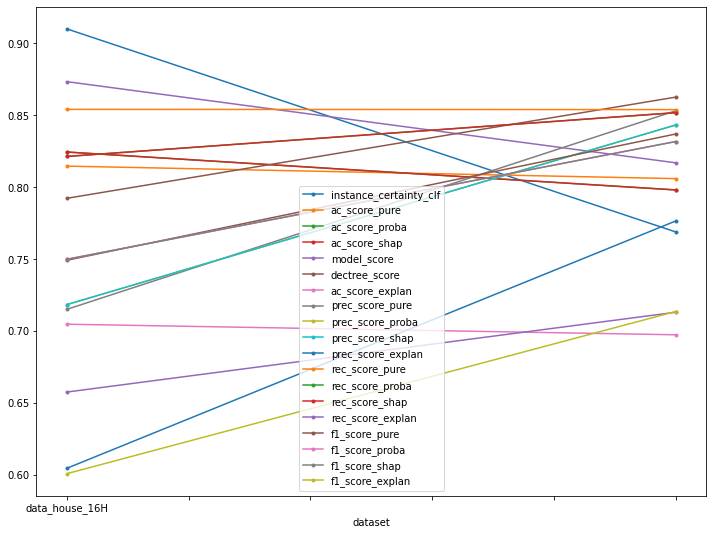

In [27]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_pure','ac_score_proba','ac_score_shap', 'model_score', 'dectree_score','ac_score_explan',
                                             'prec_score_pure','prec_score_proba','prec_score_shap','prec_score_explan',
                        'rec_score_pure','rec_score_proba','rec_score_shap','rec_score_explan',
                        'f1_score_pure','f1_score_proba','f1_score_shap','f1_score_explan'])
results_fid.groupby('dataset').mean().plot(style='.-',figsize=(12,9))
                       

In [28]:
#all-one
results_fid.mean()

instance_certainty_clf    0.839456
ac_score_pure             0.810253
ac_score_proba            0.811216
ac_score_shap             0.811216
model_score               0.845135
dectree_score             0.827399
ac_score_explan           0.700922
prec_score_pure           0.784017
prec_score_proba          0.780732
prec_score_shap           0.780732
prec_score_explan         0.690374
rec_score_pure            0.853992
rec_score_proba           0.836555
rec_score_shap            0.836555
rec_score_explan          0.685155
f1_score_pure             0.793015
f1_score_proba            0.790735
f1_score_shap             0.790735
f1_score_explan           0.657029
dtype: float64

In [56]:
#numercial 50 samples
results_fid.mean()

instance_certainty_clf    0.837867
ac_score_pure             0.836202
ac_score_proba            0.849638
ac_score_shap             0.847003
model_score               0.864541
dectree_score             0.843649
ac_score_explan           0.799064
dtype: float64

In [53]:
#numercial deep
results_fid.mean()

instance_certainty_clf    0.797500
ac_score_pure             0.786983
ac_score_proba            0.789604
ac_score_shap             0.792024
model_score               0.778030
dectree_score             0.778717
ac_score_explan           0.581521
dtype: float64

In [44]:
#categorical
results_fid.mean()

instance_certainty_clf    0.797500
ac_score_pure             0.786983
ac_score_proba            0.789604
ac_score_shap             0.792024
model_score               0.778030
dectree_score             0.778717
ac_score_explan           0.581521
dtype: float64

In [37]:
#numercial
results_fid.mean()

instance_certainty_clf    0.894800
ac_score_pure             0.890830
ac_score_proba            0.904819
ac_score_shap             0.907898
model_score               0.911731
dectree_score             0.895714
ac_score_explan           0.862227
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'instance_certainty_clf'),
  Text(1, 0, 'ac_score_pure'),
  Text(2, 0, 'ac_score_proba'),
  Text(3, 0, 'ac_score_shap'),
  Text(4, 0, 'model_score'),
  Text(5, 0, 'dectree_score'),
  Text(6, 0, 'ac_score_explan'),
  Text(7, 0, 'prec_score_pure'),
  Text(8, 0, 'prec_score_proba'),
  Text(9, 0, 'prec_score_shap'),
  Text(10, 0, 'prec_score_explan'),
  Text(11, 0, 'rec_score_pure'),
  Text(12, 0, 'rec_score_proba'),
  Text(13, 0, 'rec_score_shap'),
  Text(14, 0, 'rec_score_explan'),
  Text(15, 0, 'f1_score_pure'),
  Text(16, 0, 'f1_score_proba'),
  Text(17, 0, 'f1_score_shap'),
  Text(18, 0, 'f1_score_explan')])

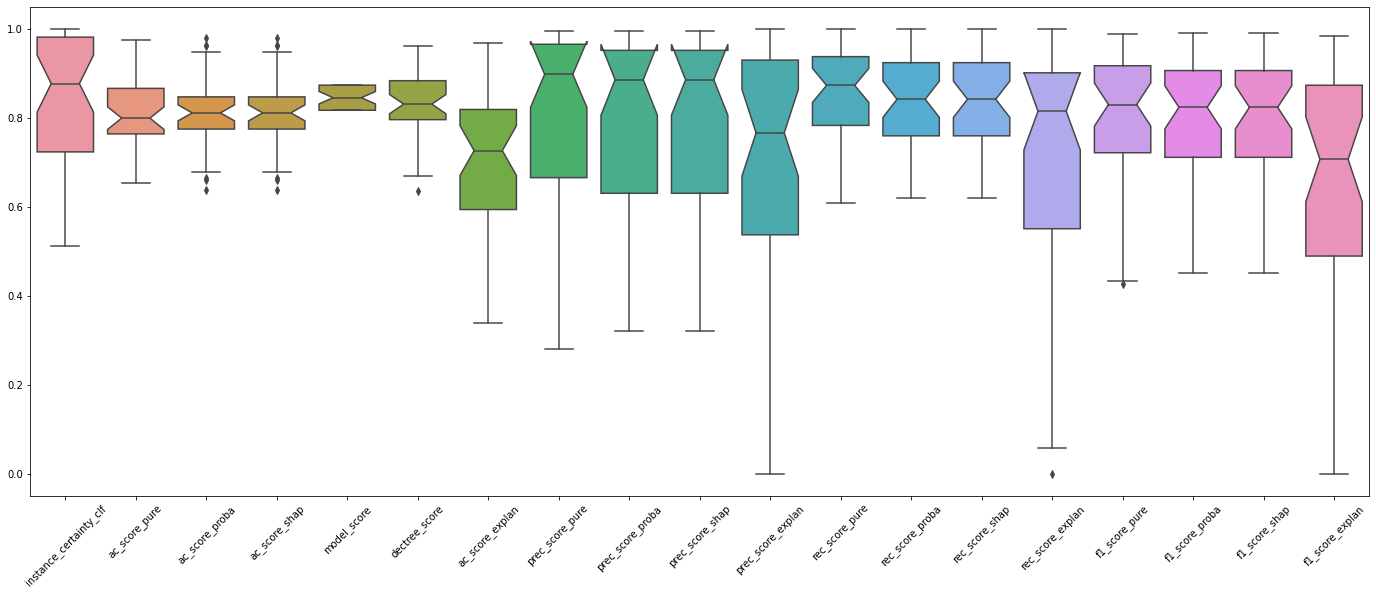

In [29]:
#one-s
fig, ax = plt.subplots(figsize=(24,9))
sns.boxplot(data=results_fid,notch=True,ax=ax)
plt.xticks(rotation=45)

<AxesSubplot:>

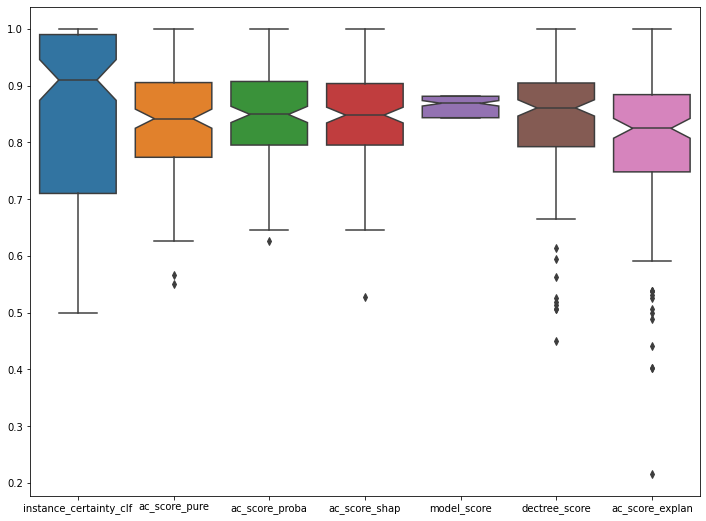

In [57]:
#num 50 samples
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_fid,notch=True,ax=ax)

<AxesSubplot:>

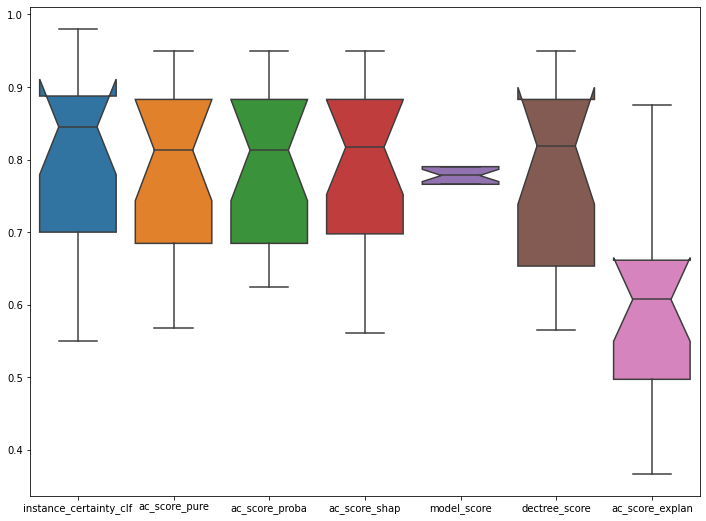

In [45]:
#categorical
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_fid,notch=True,ax=ax)

<AxesSubplot:>

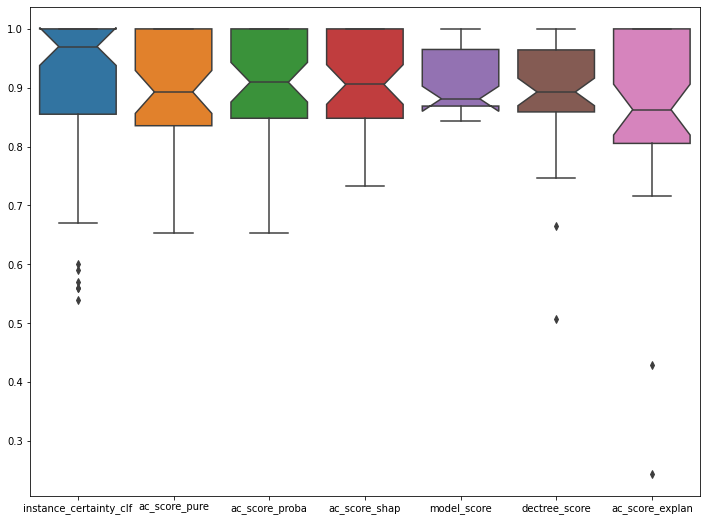

In [38]:
#numerical
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_fid,notch=True,ax=ax)

<AxesSubplot:xlabel='dataset'>

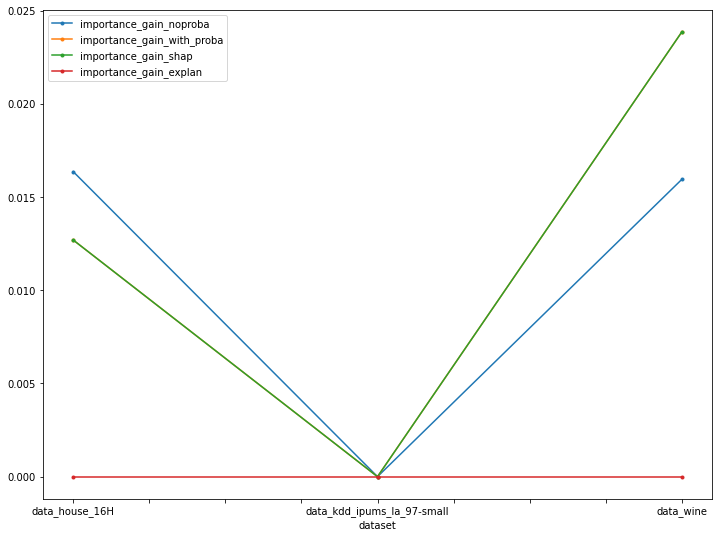

In [17]:
results_imp_fid = pd.DataFrame(imp_fid_data,columns=['dataset','num_and_cat','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan'])
results_imp_fid.groupby('dataset').mean().plot(style='.-',figsize=(12,9))
                       

In [18]:
results_imp_fid.mean()

importance_gain_noproba       0.012433
importance_gain_with_proba    0.014064
importance_gain_shap          0.014064
importance_gain_explan        0.000000
dtype: float64

<AxesSubplot:>

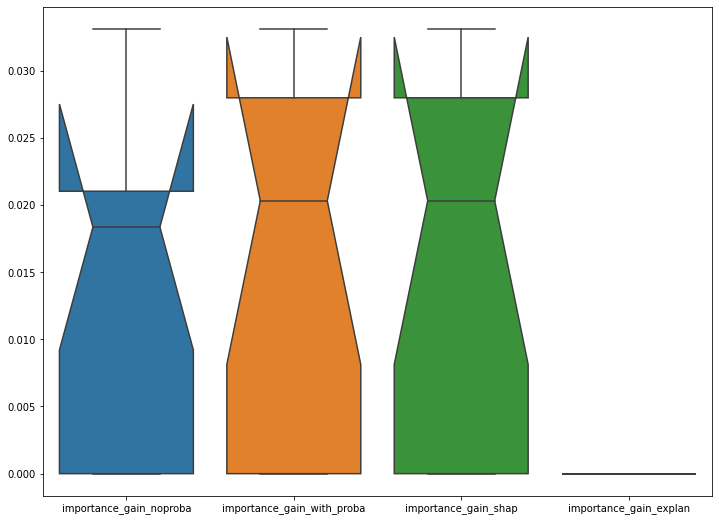

In [19]:
#one-shot
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=True,ax=ax)

<AxesSubplot:>

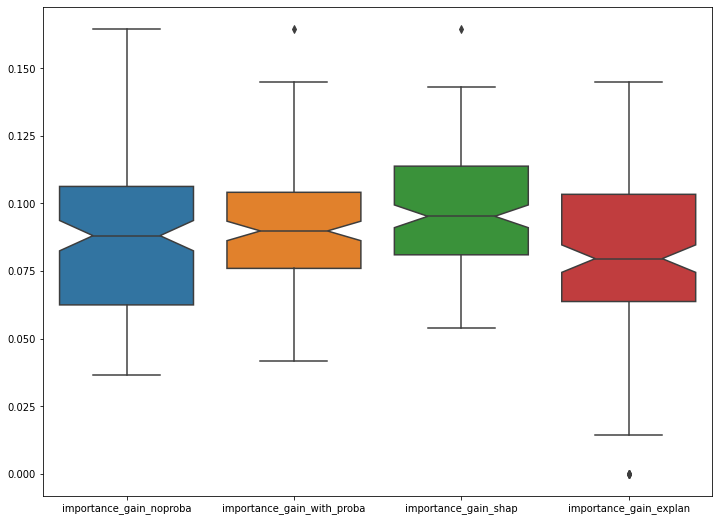

In [60]:
#categorical
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=True,ax=ax)

<AxesSubplot:>

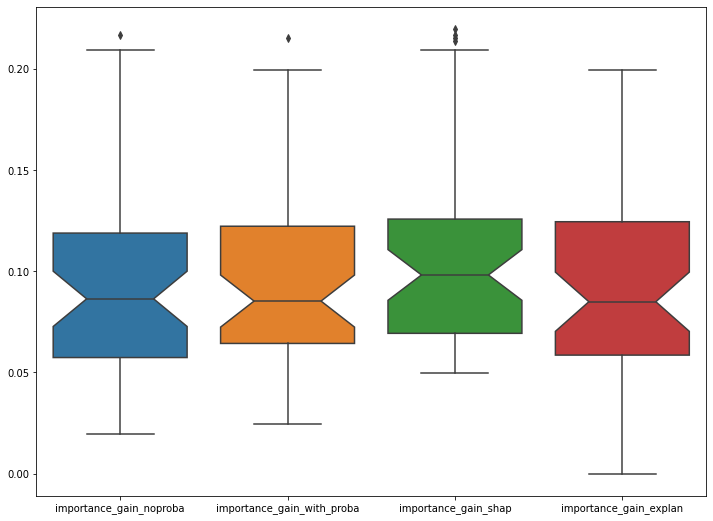

In [41]:
#with shap only
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=True,ax=ax)

In [ ]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_pure','ac_score_proba','ac_score_shap', 'model_score', 'dectree_score'])
results_fid[['ac_score_shap', 'dectree_score','ac_score_proba']].plot(figsize=(12,9))

In [ ]:
results.to_csv('results_background_subset_set_real_f02n02.csv',index=False)

In [48]:
directory = ['./data/numerical_only/balanced', './data/num_and_cat/balanced']
for d in directory:
    for num_and_cat in  os.listdir(d):
        if d == './data/num_and_cat/balanced':
            (data, y, categorical_indicator) = pickle.load(open(f'{d}/{num_and_cat}','rb'))
        else:
            (data, y) = pickle.load(open(f'{d}/{num_and_cat}','rb'))
            categorical_indicator=[False]*len(features)
        features = [f'f_{i}' for i in range(0,data.shape[1])]
        continuous_indicator = np.logical_not(categorical_indicator)
        target = 'class'
        df = pd.DataFrame(data,columns=features,dtype=float)
        df[target] = y
        df.to_csv(f'./tmp/{num_and_cat}.csv',index=False)
        